### **ESTIMATING AQUEOUS SOLUBILITY FROM MOLECULAR STRUCTURE**
##### **REF: doi.org/10.1021/ci034243x**  
---
"We have probably seen the application of machine learning in one form or another. For instance, machine learning have been used together with computer vision in self-driving cars and self-checkout convenience stores, in retail for market basket analysis (i.e. finding products that are usually purchased together), in entertainment for recommendation systems and the list goes on."

#### We will understand how machine learning could be used within the drug discovery pipeline, and in particular we will see a step-by-step procedure to build a simple regression model in Python for predicting the solubility of molecules.
---

#### **1.0 - Importing data from database**
Chemical structures are encoded by a string of text known as the 
SMILES notation which is an acronym for Simplified Molecular-Input Line-Entry System. 
Let’s have a look at the contents of the SMILES column from the sol dataframe.
Each line represents a unique molecule. 
To select the first molecule (the first row), type sol.SMILES[0] and the output that we will see is ClCC(Cl)(Cl)Cl.

In [2]:
import pandas as pd
dataset = pd.read_csv('data/delaney.csv')
dataset
dataset.SMILES[0]

'ClCC(Cl)(Cl)Cl'

In [3]:
dataset

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


#### **1.1 Converting a molecule from the SMILES string to rdkit object** 

In [4]:
#Convert a molecule from the SMILES string to an rdkit object
#Let’s start by importing the necessary library function:
from rdkit import Chem
#Now, apply the MolFromSmiles() function to convert the SMILES string to an rdkit molecule object:
m = Chem.MolFromSmiles('O')
m.GetNumAtoms()

1

In [5]:
#Iteration through the list of SMILES strings.
from rdkit import Chem
mol_list= []
for element in dataset.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)
#Next, we will check that the newly rdkit objects are populating the mol_list variable or not.
len(mol_list)

1144

#### **1.2 Calculate molecular descriptors**
---------------------------------
We will now represent each of the molecules in the dataset by a set of molecular descriptors that will be used for model building.

To predict the aqueous solubility, we will use 4 molecular descriptors:

**MW (Molecular weight)**

**RB (Number of rotatable bonds)**

**cLogP (Octanol-water partition coefficient)**

**AP (Aromatic proportion = number of aromatic atoms / number of heavy atoms)**

Unfortunately, rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the number of aromatic atoms to the total number of heavy atoms which rdkit can compute.

In [6]:
#Calculating LogP, MW and RB descriptors
#----------------------------------------
#We will now create a custom function called generate() for computing the 3 descriptors LogP, MW and RB.
import numpy as np
from rdkit.Chem import Descriptors

def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    columnNames=["MolLogP","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

Let’s apply the generate() function perform the actual descriptor calculation on sol.SMILES (the SMILES column from the df dataframe) and assign the descriptor output to the df variable.

In [7]:
df = generate(dataset.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


**Number of aromatic atoms**

Here, we will create a custom function to calculate the Number of aromatic atoms. 

With this descriptor we can use it to subsequently calculate the AP descriptor.


Example for computing the number of aromatic atoms for a single molecule.

In [8]:
SMILES = 'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21'
m = Chem.MolFromSmiles(SMILES)
aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aromatic_atoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

Let’s now create a custom function called AromaticAtoms().

In [9]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [10]:
#Now, apply the AromaticAtoms() function to compute the number of aromatic atoms for a query SMILES string.
AromaticAtoms(m)


19

In [11]:
#Let’s now scale up and apply this to the entire SMILES list.
import pandas as pd
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
#Yes! We now have computed the number of aromatic atoms for the entire dataset.
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

**Number of heavy atoms**

Here, we will use an existing function from the rdkit library for calculating the number of heavy atoms.

Example for computing the number of heavy atoms for a single molecule.

In [12]:
SMILES = 'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21'
m = Chem.MolFromSmiles(SMILES)
Descriptors.HeavyAtomCount(m)

34

In [13]:
#Let’s scale up to the entire SMILES list.
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount

[6,
 5,
 6,
 5,
 8,
 4,
 4,
 8,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 4,
 8,
 4,
 5,
 8,
 8,
 10,
 12,
 4,
 9,
 9,
 9,
 15,
 8,
 4,
 8,
 8,
 5,
 8,
 8,
 12,
 12,
 8,
 6,
 8,
 8,
 10,
 8,
 12,
 12,
 5,
 12,
 6,
 14,
 11,
 22,
 15,
 5,
 5,
 8,
 7,
 11,
 9,
 6,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 8,
 7,
 11,
 6,
 4,
 11,
 10,
 13,
 12,
 8,
 7,
 7,
 17,
 7,
 6,
 7,
 6,
 5,
 8,
 11,
 4,
 7,
 14,
 11,
 15,
 9,
 11,
 11,
 13,
 6,
 10,
 9,
 9,
 19,
 9,
 8,
 8,
 16,
 6,
 5,
 5,
 9,
 4,
 15,
 22,
 20,
 18,
 20,
 18,
 16,
 19,
 19,
 18,
 17,
 17,
 18,
 16,
 7,
 18,
 18,
 16,
 17,
 8,
 9,
 16,
 7,
 6,
 7,
 8,
 6,
 14,
 18,
 19,
 18,
 17,
 17,
 16,
 11,
 11,
 15,
 15,
 10,
 8,
 11,
 15,
 10,
 10,
 11,
 9,
 6,
 6,
 12,
 7,
 8,
 15,
 15,
 10,
 15,
 10,
 10,
 16,
 9,
 8,
 8,
 8,
 7,
 9,
 8,
 13,
 14,
 14,
 9,
 12,
 9,
 8,
 13,
 14,
 12,
 15,
 11,
 11,
 4,
 8,
 5,
 5,
 8,
 6,
 9,
 13,
 5,
 11,
 8,
 4,
 8,
 6,
 11,
 8,
 7,
 9,
 9,
 7,
 9,
 12,
 9,
 8,
 8,
 7,
 7,
 11,
 7,
 4,
 10,
 12,
 5,

**COMPUTING THE AROMATIC PROPORTION**

Let’s now combine the number of aromatic atoms and the number of heavy atoms together.

Example of computing for a single molecule.

In [14]:
SMILES = 'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21'
m = Chem.MolFromSmiles(SMILES)
AromaticAtoms(m)/Descriptors.HeavyAtomCount(m)

0.5588235294117647

In [15]:
#Let’s scale up and compute for the entire SMILES list.
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion=pd.DataFrame(desc_AromaticProportion)
#Now let's combine the two datasets
X = pd.concat([df,desc_AromaticProportion], axis=1)
X.to_csv('descriptors.csv', index=False)
X

,MolLogP,MolWt,NumRotatableBonds,0
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


The Y matrix will be created from 1 column that we are going to predict in this tutorial and this is the LogS value. In the sol dataframe, the LogS values are contained within the measured log(solubility:mol/L) column.
Let’s have a look at the sol dataframe again.

In [16]:
dataset.to_csv('dataset.csv', index=False)

The second column (index number of 1) corresponding to the measured solubility value (LogS) will be used as the Y matrix. Thus, we will select the second column (indicated in the above image by the blue highlight)

#### **2.0 - DATA SPLIT**

We will now proceed to performing data splitting using a split ratio of 80/20 (i.e. we do this by assigning the test_size parameter to 0.2) whereby 80% of the initial dataset will be used as the training set and the remaining 20% of the dataset will be used as the testing set.

In [17]:
from sklearn.model_selection import train_test_split
Y = dataset.iloc[:,1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2)

#### ** 3.0 - LINEAR REGRESSION MODEL

As the original study by Delaney and the investigation by Walters used linear regression for model building, therefore for comparability we will also be using linear regression as well.

In [19]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
model = linear_model.LinearRegression()
X_train.columns = X_train.columns.astype(str)
model.fit(X_train, Y_train)

LinearRegression()

#### **4.0 - REGRESSION AND CORRELATION COEFFICIENTS**

The trained model will be applied here to predict the LogS values in the **train** and **test** set

In [20]:
#TRAINING SET

Y_pred_train = model.predict(X_train)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.71331778 -0.00683822  0.00390056 -0.46852774]
Intercept: 0.22505944176282489
Mean squared error (MSE): 1.00
Coefficient of determination (R^2): 0.77


Let’s analyse the above output line by line:
In the first line, Coefficients lists the regression coefficient values of each independent variables (i.e. the 4 molecular descriptors consisting of LogP, MW, RB and AP)
In the second line, Intercept is essentially the y-intercept value where the regression line passes when X = 0.
In the third line, Mean squared error (MSE) is used as an error measure (i.e. the lower the better).
In the fourth line, Coefficient of determination (R²) is the squared value of Pearson’s correlation coefficient value and is used as a measure of goodness of fit for linear regression models (i.e. the higher the better)

In [22]:
# TEST SET
X_test.columns = X_test.columns.astype(str)
Y_pred_test = model.predict(X_test)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.71331778 -0.00683822  0.00390056 -0.46852774]
Intercept: 0.22505944176282489
Mean squared error (MSE): 1.05
Coefficient of determination (R^2): 0.75


#### **5.0 - DERIVING THE LINEAR EQUATION**

In [23]:
yintercept = '%.2f' % model.intercept_
LogP = '%.2f LogP' % model.coef_[0]
MW = '%.4f MW' % model.coef_[1]
RB = '%.4f RB' % model.coef_[2]
AP = '%.2f AP' % model.coef_[3]
print('LogS = ' + 
      ' ' + 
      yintercept + 
      ' ' + 
      LogP + 
      ' ' + 
      MW + 
      ' ' + 
      RB + 
      ' ' + 
      AP)

LogS =  0.23 -0.71 LogP -0.0068 MW 0.0039 RB -0.47 AP


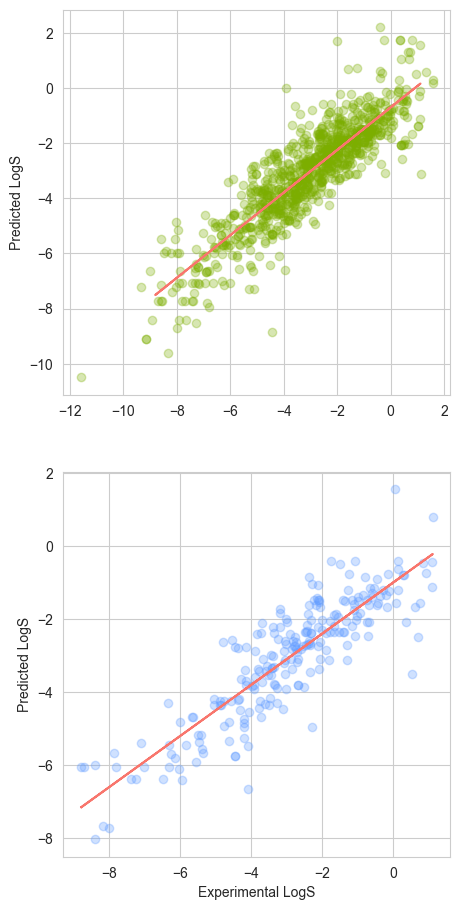

In [26]:
#Let’s now visualise the correlation of the Experimental LogS values with 
# those of the Predicted LogS values by means of the scatter plot.
# We will be displaying the Experimental vs Predicted values of LogS separately in 2 scatter plots
# Before plotting, convert Y_test to a NumPy array
Y_test = Y_test.values  # or np.array(Y_test)


import matplotlib.pyplot as plt
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()